In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [2]:
data_train = np.loadtxt('../data/hw6/svm-train.txt')
data_test = np.loadtxt('../data/hw6/svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [3]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

In [4]:

class Decision_Tree(BaseEstimator):
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method for splitting node
        :param leaf_value_estimator: method for estimating leaf value
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth

    def fit(self, X, y=None):
        """
        This should fit the tree classifier by setting the values self.is_leaf,
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recursive tree building procedure.

        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        """
        self.is_leaf = False
        n_ins, n_feat = X.shape

        if n_ins <= self.min_sample or self.depth >= self.max_depth:
            self.value = self.leaf_value_estimator(y)
            self.is_leaf = True
            return self

        measure = np.inf
        for j in range(n_feat):
            idx = X[:, j].argsort()
            X_sort = X[idx]
            y_sort = y[idx]
            for i in range(1, n_ins):
                k = self.split_loss_function(y_sort[:i])*i + self.split_loss_function(y_sort[i:])*(n_ins-i)
                if k < measure:
                    measure = k
                    self.split_id = j
                    self.split_value = (X_sort[i - 1, j] + X_sort[i, j]) / 2

        mask = X[:, self.split_id] <= self.split_value
        mask[0], mask[-1] = True, False
        self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth+1,
                                  self.min_sample, self.max_depth)
        self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth+1,
                                   self.min_sample, self.max_depth)
        self.left.fit(X[mask], y[mask])
        self.right.fit(X[~mask], y[~mask])

    def predict_instance(self, instance):
        """
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        """
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [5]:
def compute_entropy(label_array):
    """
    Calculate the entropy of given label list

    :param label_array: a numpy array of labels shape = (n, 1)
    :return entropy: entropy value
    """
    n_ins = len(label_array)
    _, count = np.unique(label_array, return_counts=True)
    count = count.astype(np.float64)
    count /= n_ins
    entropy = -np.sum(count*np.log2(count))
    return entropy

def compute_gini(label_array):
    """
    Calculate the gini index of label list

    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    """
    n_ins = len(label_array)
    _, count = np.unique(label_array, return_counts=True)
    count = count.astype(np.float64)
    count /= n_ins
    gini = np.sum(count*(1-count))
    return gini

In [6]:
def most_common_label(y):
    """
    Find most common label
    """
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [7]:

class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        """
        :param loss_function(str): loss function for splitting internal node
        """

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value


# Decision Tree Boundary

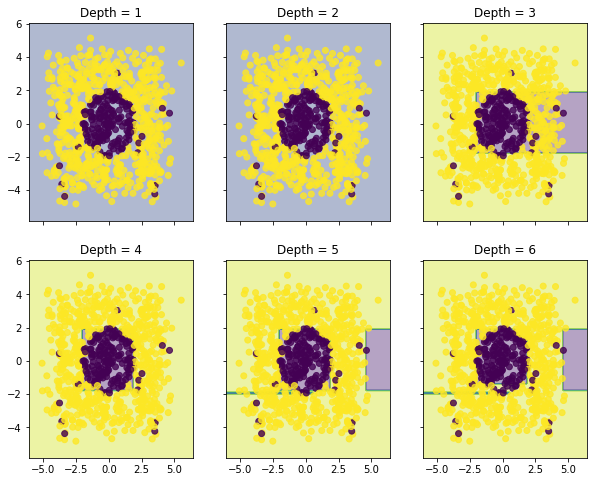

In [8]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.savefig('../figures/hw6/clf_tree.png')

# Compare decision tree with tree model in sklearn

In [9]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

In [10]:
# Visualize decision tree
graphviz.render('dot', 'png', 'tree_classifier.dot')

'tree_classifier.dot.png'

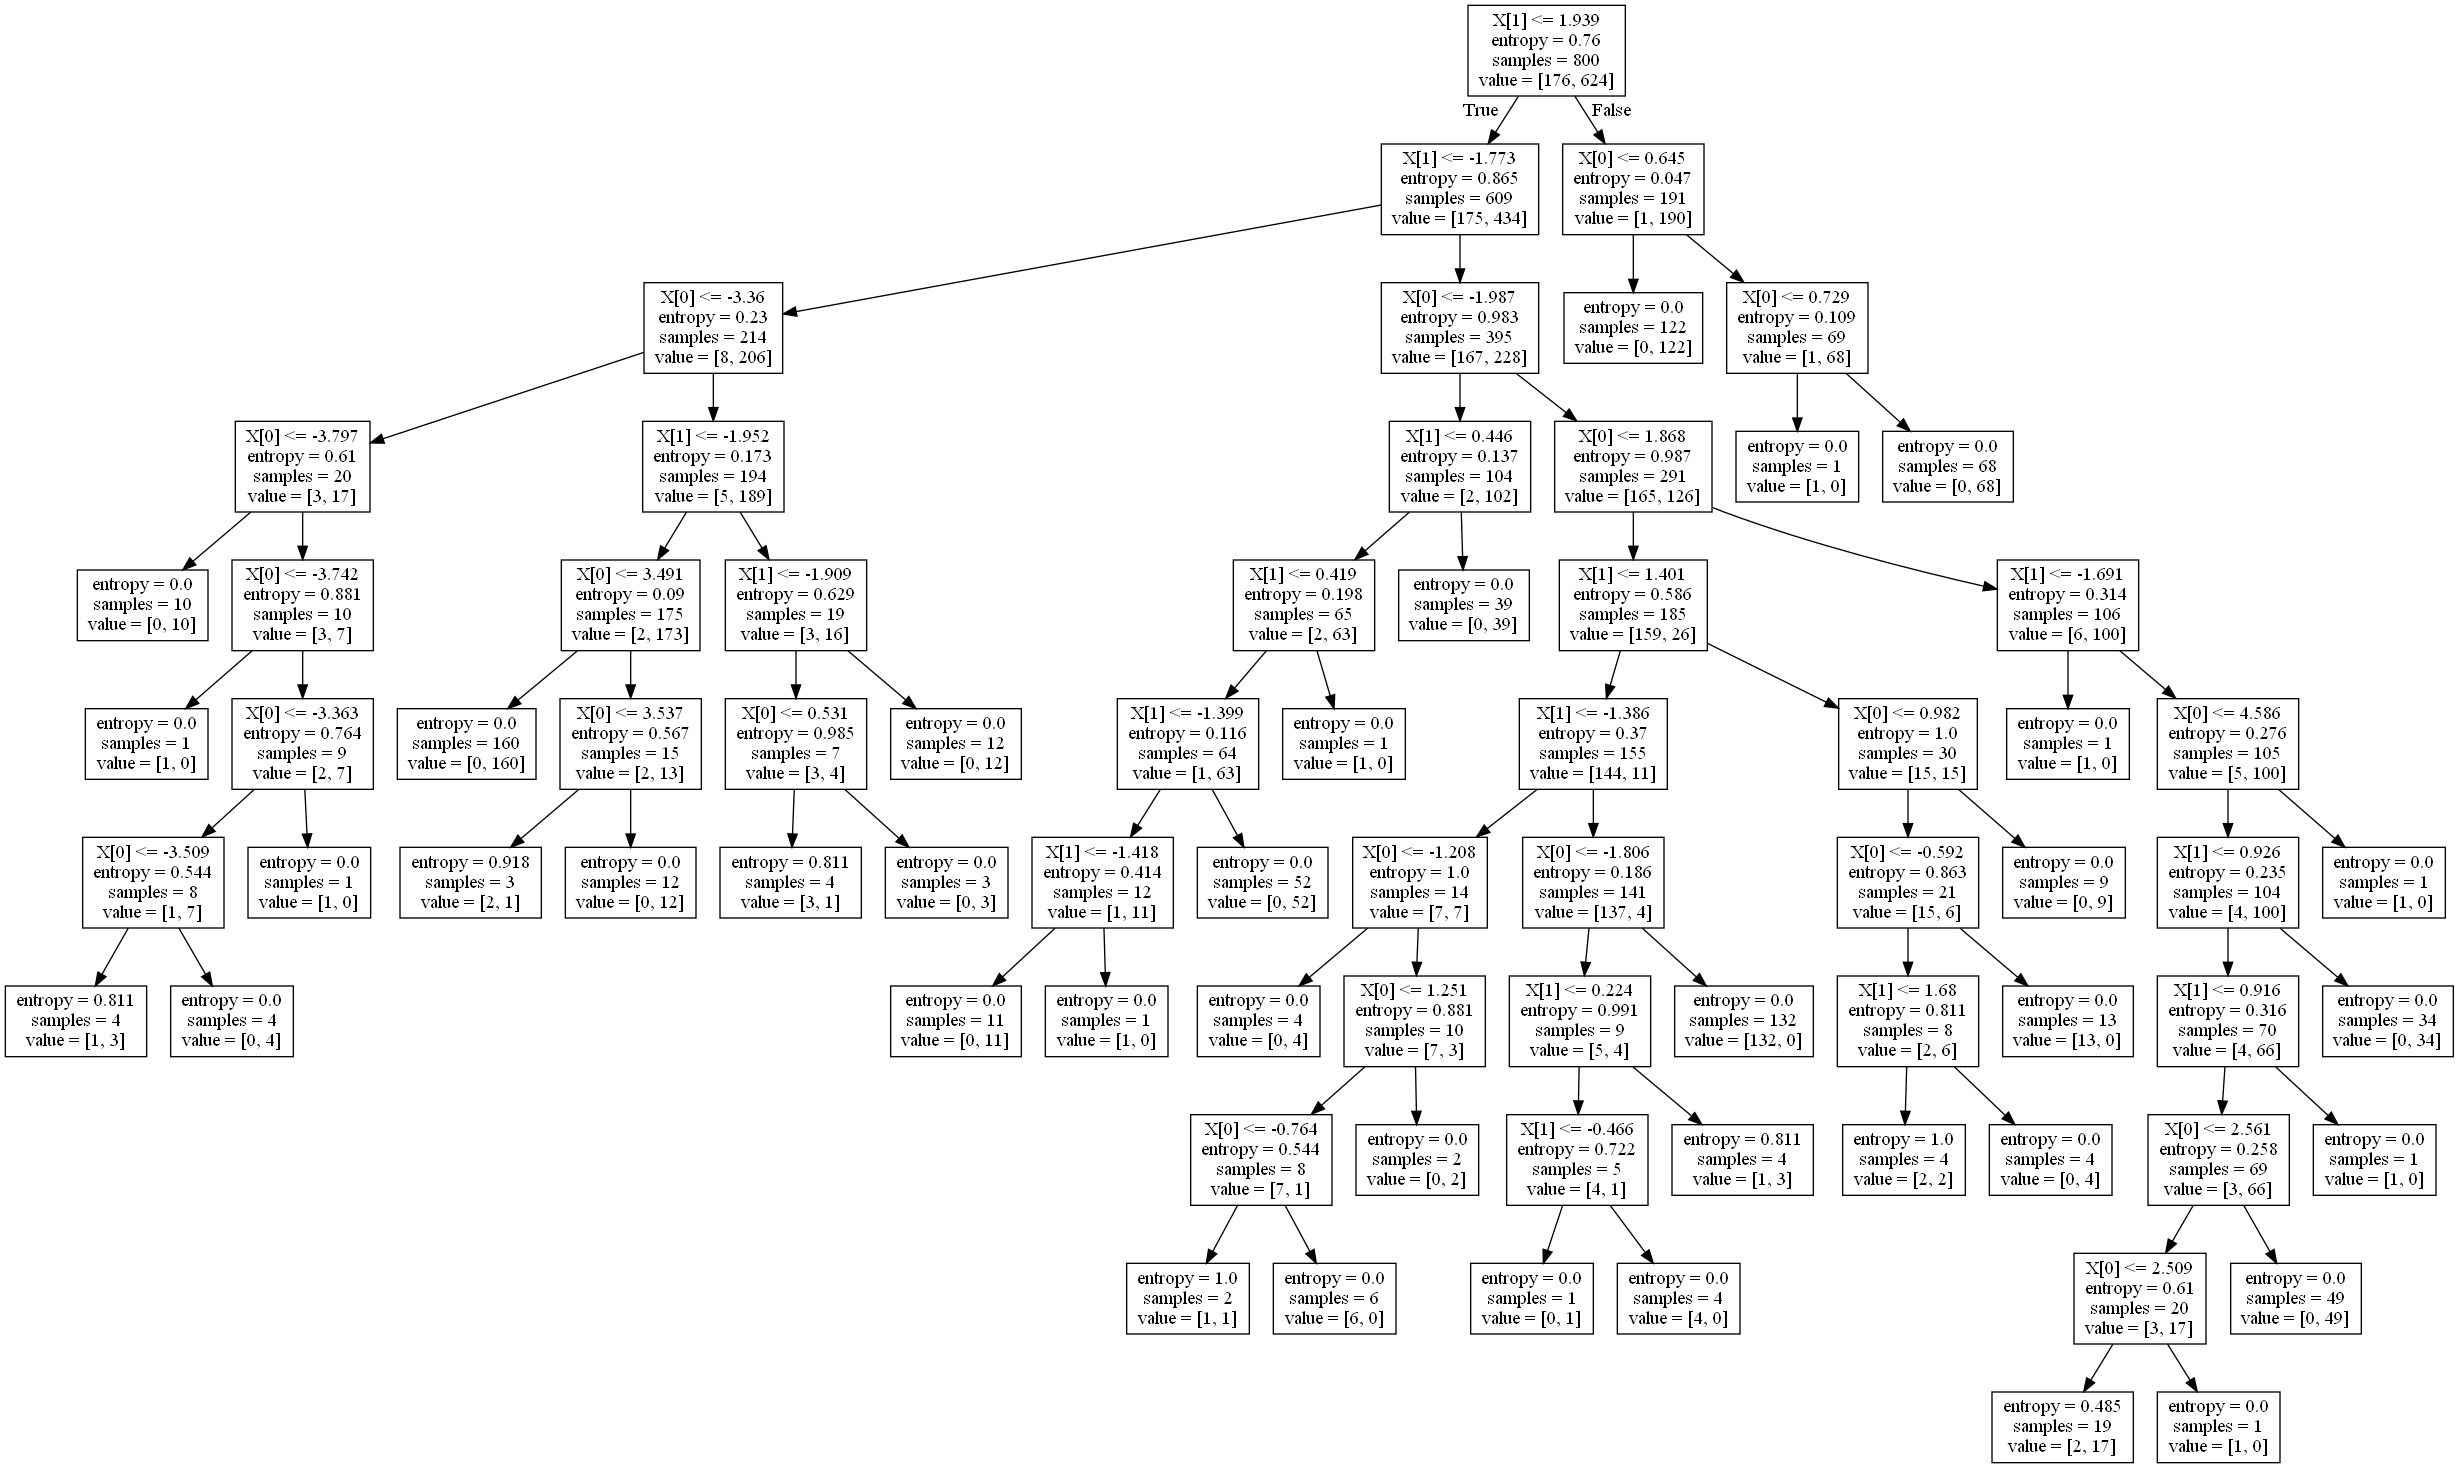

In [11]:
Image(filename='tree_classifier.dot.png')

# Decision Tree Regressor

In [12]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    """
    Calulate the mean absolute deviation around the median of a given target list

    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    """
    n_ins = len(y)
    mean = np.mean(y)
    mae = np.sum(np.abs(y-mean)) / n_ins
    return mae

In [13]:
class Regression_Tree:
    """
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    """

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        """
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        """

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value


# Fit regression tree to one-dimensional regression data

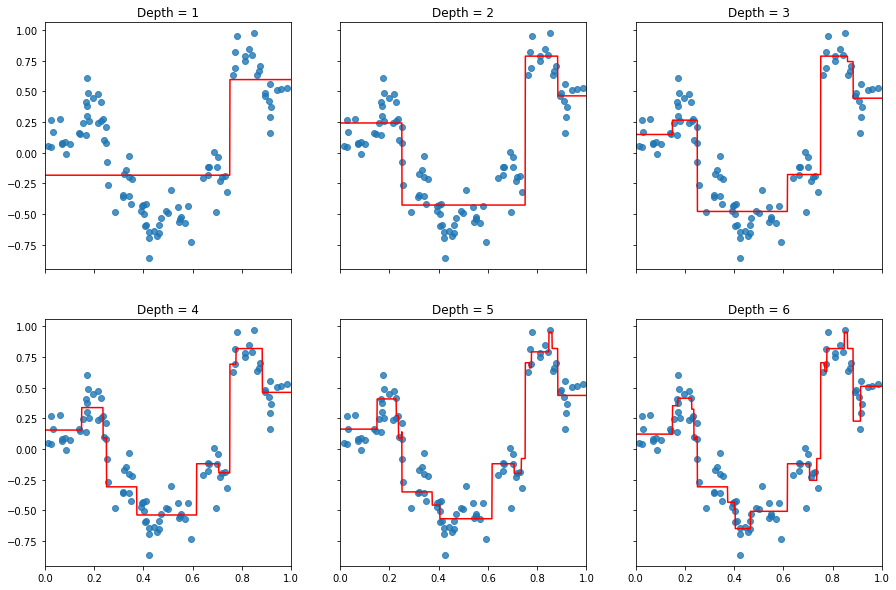

In [14]:
data_krr_train = np.loadtxt('../data/hw6/krr-train.txt')
data_krr_test = np.loadtxt('../data/hw6/krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:, 0].reshape(-1, 1), data_krr_train[:, 1].reshape(-1, 1)
x_krr_test, y_krr_test = data_krr_test[:, 0].reshape(-1, 1), data_krr_test[:, 1].reshape(-1, 1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=1, loss_function='mae', estimator='median')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=1, loss_function='mae', estimator='median')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=1, loss_function='mae', estimator='median')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=1, loss_function='mae', estimator='median')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=1, loss_function='mae', estimator='median')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=6,  min_sample=1, loss_function='mae', estimator='median')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

plt.savefig('../figures/hw6/rgr_tree.png')

# Gradient Boosting Method

In [15]:
# Pseudo-residual function.
# Here you can assume that we are using L2 loss


def pseudo_residual_l2(train_target, train_predict):
    """
    Compute the pseudo-residual based on current predicted value.
    """
    return train_target - train_predict

In [16]:
class GradientBoosting:
    """
    Gradient Boosting regressor class
    :method fit: fitting model
    """
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.1, min_sample=5, max_depth=3):
        """
        Initialize gradient boosting class

        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :param pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        """
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
    
    def fit(self, train_data, train_target):
        """
        Fit gradient boosting model
        """
        train_target = train_target.flatten()
        self.base_estimators = []
        for i in range(self.n_estimator):
            self.base_estimators.append(DecisionTreeRegressor(max_depth=self.max_depth,
                                                              min_samples_leaf=self.min_sample))
        n_ins = len(train_data)
        pred = np.zeros(n_ins)
        for est in self.base_estimators:
            psd_res = self.pseudo_residual_func(train_target, pred)
            est.fit(train_data, psd_res)
            pred += self.learning_rate*est.predict(train_data)
    
    def predict(self, test_data):
        """
        Predict value
        """
        pred = self.learning_rate*np.sum([est.predict(test_data) for est in self.base_estimators], axis=0)
        return pred


# 2-D GBM visualization - SVM data

D:\anaconda3\envs\Python_ML_Alg\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


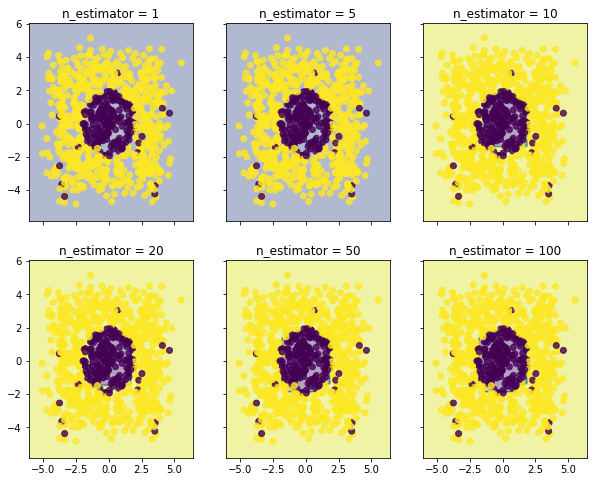

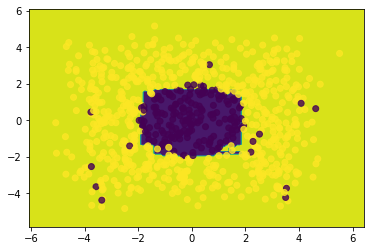

In [19]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = GradientBoosting(n_estimator=i, pseudo_residual_func=pseudo_residual_l2, max_depth=2)
    gbt.fit(x_train, y_train)
                   
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.savefig('../figures/hw6/GBT_clf.png')

# Use sklearn class to compare the running result.

from sklearn.ensemble import GradientBoostingRegressor

ref_gbt = GradientBoostingRegressor(criterion='mse', min_samples_leaf=5)
ref_gbt.fit(x_train, y_train)
Z = np.sign(ref_gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
plt.figure(2)
f = plt.contourf(xx, yy, Z)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
plt.savefig('../figures/hw6/GBT_skl.png')

# 1-D GBM visualization - KRR data

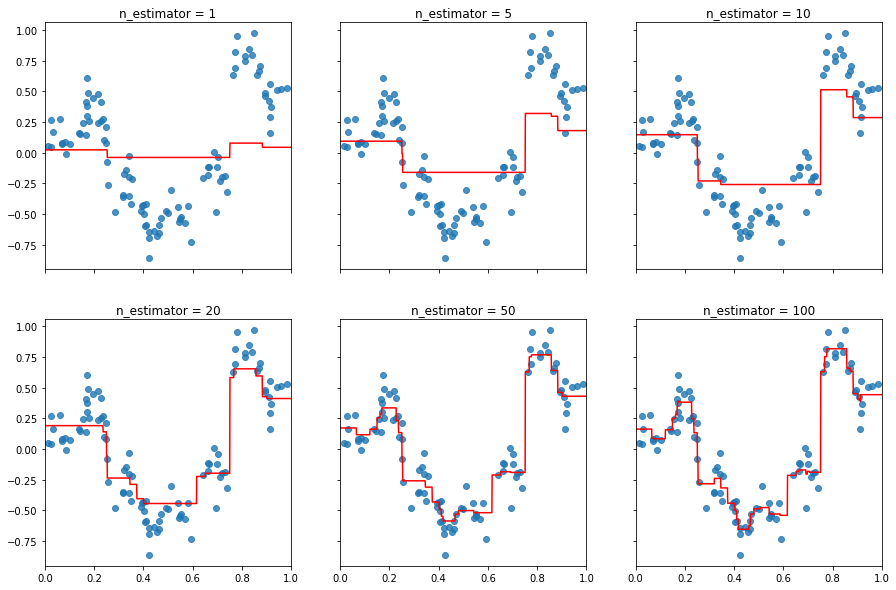

In [18]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = GradientBoosting(n_estimator=i, pseudo_residual_func=pseudo_residual_l2, max_depth=2)
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

plt.savefig('../figures/hw6/GBT_rgr.png')